# Imports

In [1]:
# general purpose
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import heapq
from tqdm.autonotebook import tqdm
from scipy import stats
import cv2
from collections import Counter
import warnings

# metrics and model selection
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error

# deep learning - general
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim import SGD, AdamW
from torch.optim.lr_scheduler import StepLR

# deep learning - vision utils & pretrained models
from torchvision.io import read_image, ImageReadMode
from torchvision.transforms.v2 import (
    RandomHorizontalFlip, TrivialAugmentWide, 
    Compose, Resize, ConvertDtype
)
from torchvision.transforms.functional import to_pil_image
from torchvision.models import (
    EfficientNet_V2_M_Weights, efficientnet_v2_m,
    ResNet50_Weights, resnet50
)


# customary cuda detection
device = "cuda" if torch.cuda.is_available else "cpu"
device

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_28/3102470082.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You 

'cuda'

# Utils

In [2]:
ROOT_PATH = Path("../input/how-much-would-you-pay-for-a-fake-cat/")
IMG_PATH = ROOT_PATH / "images" / "images"

In [3]:
# faster than via numpy's argpartition
def topk(arraylike, k=10):
    return np.sort(heapq.nlargest(k,arraylike))

In [4]:
# display images from tensors
def show(imgs, size=None):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=size)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [5]:
# read images - possibly all of them
def read_img(img_id):
    img_path = IMG_PATH / (img_id + ".png")
    return read_image(str(img_path),mode=ImageReadMode.RGB)
    
def read_all_imgs(img_ids, out_sz=(480,480)):
    preprocess = Compose([
            Resize(out_sz, antialias=True),
            ConvertDtype(torch.float)
    ])
    return [preprocess(read_img(img_id)) for img_id in tqdm(img_ids)]

In [6]:
# training, evaluation and prediction utility functions
def train_one_epoch(model, optimizer, criterion, train_dataloader, device, print_frequency=None, scheduler=None):
    model.train()
    for idx, (imgs, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        imgs, targets = imgs.to(device), targets.to(device)
        preds = model(imgs)
        
        # fix (n_pred, 1)-shaped predictions
        if len(preds.shape)>1:
            preds = preds.squeeze(-1)
        
        loss = criterion(targets, preds)
        
        if print_frequency is not None and (idx+1)%print_frequency == 0:
            print(f"Loss at iter {idx+1: >5}: {loss.cpu().detach().item(): .4f}")
        loss.backward()
        
        optimizer.step()
        
        if scheduler is not None:
            scheduler.step()
            
def evaluate(model, test_dataloader, device, clip=False):
    model.eval()
    
    residuals = torch.empty((len(test_dataloader)), device=device)
    preds = torch.empty((len(test_dataloader)), device=device)
    with torch.no_grad():
        for idx, (img, target) in enumerate(test_dataloader):
            output = model(img.to(device)).squeeze()
            preds[idx] = output
            residuals[idx] = preds[idx] - target.to(device)
        
        # MAE
        mae = residuals.abs().mean(0).cpu().detach().item()
        preds = preds.cpu().detach()
    
    return mae, preds           

def predict(model, test_dataloader, device, use_tqdm=True):
    model.eval()
    preds = torch.empty((len(test_dataloader)), device=device)
    with torch.no_grad():
        iterator = enumerate(test_dl)
        if use_tqdm:
            iterator = tqdm(iterator, total=len(test_dl))
        for idx, img in iterator:
            preds[idx] = model(img.to(device)).squeeze()
    return preds.cpu().detach().numpy()

In [7]:
# submitting
def submit(preds, out_name):
    submission = test_df[["id"]].copy()
    submission["price"] = preds
    submission.to_csv(out_name+".csv", index=False)

# Loading data

In [8]:
train_df = pd.read_csv(ROOT_PATH / "train.csv")
test_df = pd.read_csv(ROOT_PATH / "test.csv")

# Quick glance at data

In [9]:
# peek at training data
train_df.head()

,id,price,speed,image
0,7d46fd31038904e2,2.13,Fast (1m),./images/7d46fd31038904e2.png
1,76690b9129b9895c,0.46,Catatonic (1w),./images/76690b9129b9895c.png
2,c5f9966acce22205,10,Swift (2m),./images/c5f9966acce22205.png
3,dfcbc3748fa8e4ba,2,Catatonic (1w),./images/dfcbc3748fa8e4ba.png
4,eefb9c589f2ad43a,1,Snappy (10m),./images/eefb9c589f2ad43a.png


For each observation we have:

* **id**: the image id
* **price**: how much ETH it costs. This is the target variable.
* **speed**: the cooldown time for the NFT image.
* **image**: the (broken @ Kaggle FS) path to the image. 

Note that [as specified in the competition](https://www.kaggle.com/competitions/how-much-would-you-pay-for-a-fake-cat/data), the image path always has the "image/"+ id + ".png" format, hence the image path is a redundant feature.

In [10]:
# drop the "image" feature as it's of no use
for df in (train_df, test_df):
    df.drop(columns=["image"], inplace=True)

In [11]:
# types + any missing values?
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   object
 1   price   2000 non-null   object
 2   speed   2000 non-null   object
dtypes: object(3)
memory usage: 47.0+ KB


## Price



In [12]:
# weird that it's a string, is there some weird character around?
for x in train_df["price"].unique():
    try:
        x = float(x)
    except ValueError as e:
        print(x,"---", str(e))

1,000,000 --- could not convert string to float: '1,000,000'
19,999.995 --- could not convert string to float: '19,999.995'
10,000 --- could not convert string to float: '10,000'
15,000 --- could not convert string to float: '15,000'


In [13]:
# deleting the commas as they make no difference + converting to float
train_df["price"] = train_df["price"].str.replace(",","").astype(float)

In [14]:
# general stats for the target variable
train_df["price"].describe()

count       2000.000000
mean         557.364824
std        22369.065663
min            0.065600
25%            0.790750
50%            1.880000
75%            8.000000
max      1000000.000000
Name: price, dtype: float64

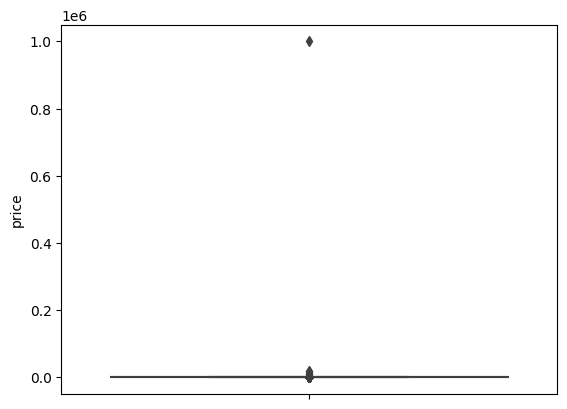

In [15]:
# coarse-grained look -- a box plot
sns.boxplot(train_df, y="price")
plt.show()

We can see two things:
* The data is highly skewed
* There seem to be *a lot* of values outside the Q1-Q3 range, and even then we have a clear outlier on top.

In [16]:
topk(train_df["price"], k=10)

array([   1000.   ,    1001.   ,    1999.   ,    2000.   ,    3999.   ,
          9999.8  ,   10000.   ,   15000.   ,   19999.995, 1000000.   ])

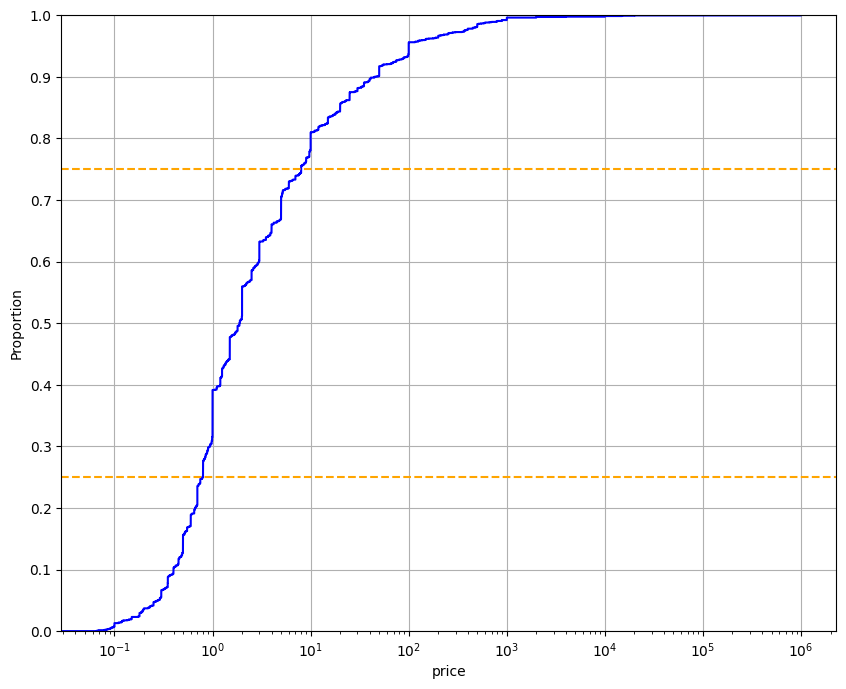

In [17]:
fig, ax = plt.subplots(figsize=(10,8))

# ECDF on log scale
ax = sns.ecdfplot(train_df,x="price",log_scale=True,ax=ax, color="blue")

# we want a finer granularity than default 0.2 -- y ticks every 0.1
ax.set_yticks(np.linspace(0,1,11))
ax.grid()

# show Q1 and Q3
for q in (0.25,0.75):
    ax.axhline(q, xmin=0, xmax=1, linestyle="dashed", color="orange")

plt.show()

1. Almost 40% of the samples cost at most 1 ETH
2. Over 90% of the samples cost below 100 ETH, the fraction raises to ~99% for 1000 ETH
3. From the top-k we know all top-5 prices are outliers

## Speed

In [18]:
# how many unique values do we find out of the 2k samples?
train_df["speed"].nunique()

14

In [19]:
# is there any unseen value at test?
set(test_df["speed"])-set(train_df["speed"])

set()

So only 14 unique values and no new ones at test, we can look at the training set ones and encode such values accordingly!

In [20]:
pd.value_counts(train_df["speed"])

speed
Fast (1m)         1067
Catatonic (1w)     389
Swift (2m)          97
Swift (5m)          76
Snappy (10m)        52
Brisk (2h)          52
Snappy (30m)        48
Brisk (1h)          42
Plodding (4h)       41
Slow (16h)          36
Plodding (8h)       27
Slow (24h)          27
Sluggish (4d)       26
Sluggish (2d)       20
Name: count, dtype: int64

This is an inherently (positive) real-valued feature that measures time interval durations. As the shortest one is 1 minute, we can encode it as the number of minutes.

In [21]:
# encoding as minutes
def encode_speed(speed):
    # faster than regex
    cd = speed.split("(")[1].split(")")[0]
    num, unit = int(cd[:-1]), cd[-1]
    translate={
        'm': 1,
        'h': 60,
        'd': 60*24,
        'w': 60*24*7
    }
    return num * translate[unit]

# test drive
sample = train_df["speed"][3]
sample, encode_speed(sample)

('Catatonic (1w)', 10080)

In [22]:
# apply encoding
for df in (train_df, test_df):
    df["speed_encoded"] = df["speed"].apply(encode_speed)
    
train_df.head()

,id,price,speed,speed_encoded
0,7d46fd31038904e2,2.13,Fast (1m),1
1,76690b9129b9895c,0.46,Catatonic (1w),10080
2,c5f9966acce22205,10.00,Swift (2m),2
3,dfcbc3748fa8e4ba,2.00,Catatonic (1w),10080
4,eefb9c589f2ad43a,1.00,Snappy (10m),10


But is it a good regressor?

<Axes: xlabel='speed_encoded', ylabel='price'>

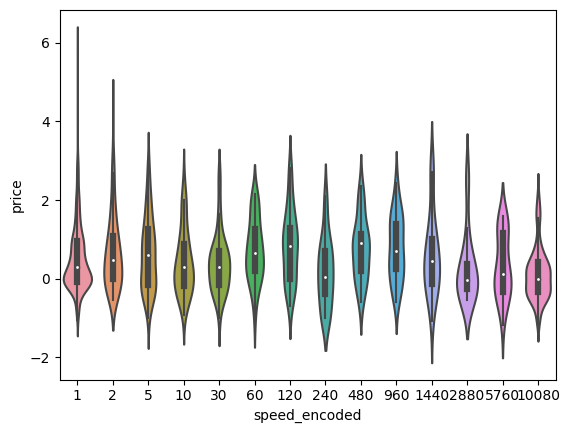

In [23]:
# plot
sns.violinplot(x=train_df["speed_encoded"], y=np.log10(train_df["price"]), log_scale=True)

In [24]:
# how well does it correlate with price?
pearson = np.corrcoef(train_df["speed_encoded"],train_df["price"])[0,1]

spearman = stats.spearmanr(train_df["speed_encoded"],train_df["price"])[0]

print(f"{pearson=:.3}\n{spearman=:.3}")

pearson=-0.0131
spearman=-0.127


While it doesn't look like a great predictor in the continuous sense, it seems that some groups are not as sparsely distributed. We can exploit this behavior on a group-wise statistic-based baseline model.

# Baseline: predicting price using only speed group statistics

In [25]:
def MAD(arraylike):
    return np.median((arraylike - np.median(arraylike)).abs())

def IQR(arraylike):
    x = np.quantile(arraylike, (0.25, 0.75))
    return x[1] - x[0]

def trimmed_mean(arraylike, p=0.05):
    lower, upper = np.quantile(arraylike, (p, 1-p))
    return arraylike[(arraylike >= lower) & (arraylike <= upper)].mean()
    

def get_measures(df):
    res = df.groupby("speed_encoded").agg({"price": [len, min,  max, 
                                                     np.median, MAD, IQR, 
                                                     np.mean, np.std, 
                                                     trimmed_mean, 
                                                     lambda x: trimmed_mean(x,0.1)]})
    # reset column index - not so straightforward
    res.columns = list(res.columns.get_level_values(1))[:-2]+[f"trimmed_mean_{p}" for p in ("05","1")]
    return res

train_measures = get_measures(train_df)
train_measures

,len,min,max,median,MAD,IQR,mean,std,trimmed_mean_05,trimmed_mean_1
speed_encoded,,,,,,,,,,
1,1067,0.0900,1000000.000,1.99000,1.3400,8.0300,1004.384214,30618.752144,8.751919,5.111013
2,97,0.2893,19999.995,3.00000,2.4000,11.2100,269.402974,2038.733219,35.186564,10.767312
5,76,0.1000,900.000,4.10000,3.6500,17.7825,43.027153,132.156737,15.875337,14.624978
10,52,0.1190,363.110,2.00000,1.6000,6.9750,19.440327,55.731578,13.482062,5.763698
30,48,0.0980,400.000,2.00000,1.5505,4.3000,22.515223,79.831875,4.594826,3.216650
60,42,0.1000,145.690,4.50000,3.7250,17.0165,21.513524,36.143604,19.923132,11.244656
120,52,0.2000,666.000,7.06715,6.2949,19.0000,55.059381,139.564765,26.114517,18.200177
240,41,0.1000,125.000,1.10000,1.0000,4.6000,10.815488,27.482553,5.600897,2.849595
480,27,0.2500,225.000,8.00000,6.8000,11.9100,25.273111,49.844977,15.510174,12.249238


In [26]:
FOLDS = 5
splitter = StratifiedKFold(FOLDS, shuffle=True, random_state=42)
oof_predictions = train_df[["speed_encoded", "price"]].copy()
features = ["mean", "median", "IQR", "MAD", "std", "trimmed_mean_05", "trimmed_mean_1"]
for feature in features:
    oof_predictions[feature] = 0

preds = {
    "mean": lambda df: df["mean"],
    "median": lambda df: df["median"],
    "tmean_05": lambda df: df["trimmed_mean_05"],
    "tmean_1": lambda df: df["trimmed_mean_1"],
    "median-IQR": lambda df: df["median"]-df["IQR"]/2,
    "median-MAD": lambda df: df["median"]-df["MAD"],
    "tmean_05-MAD": lambda df: df["trimmed_mean_05"]-df["MAD"],
    "tmean_1-MAD": lambda df: df["trimmed_mean_1"]-df["MAD"],
}

errors = {k: np.empty(FOLDS) for k in preds}

for idx, (train_idxs, test_idxs) in enumerate(splitter.split(train_df, train_df["speed_encoded"])):
    train = train_df.loc[train_idxs]
    oof = oof_predictions.loc[test_idxs]
    
    measures = get_measures(train)[features]
    merged = (
        oof[["speed_encoded"]]
        .merge(measures,left_on="speed_encoded",right_index=True)
    )
    
    for k, f in preds.items():
        errors[k][idx] = mean_absolute_error(oof["price"], f(merged))
    
    oof_predictions.loc[test_idxs, features] = merged
    
    
oof_predictions

,speed_encoded,price,mean,median,IQR,MAD,std,trimmed_mean_05,trimmed_mean_1
0,1,2.13,1249.009714,1.999,8.13775,1.3490,34224.371693,9.437960,5.081032
1,10080,0.46,7.168485,1.000,2.50370,0.7500,21.195569,3.049870,1.760552
2,2,10.00,320.029276,3.000,13.30250,2.5200,2270.822172,39.506656,11.154516
3,10080,2.00,6.591222,1.000,2.22000,0.7000,18.934472,3.840302,1.726953
4,10,1.00,22.103738,2.000,8.21250,1.5525,61.405647,14.482795,5.147781
...,...,...,...,...,...,...,...,...,...
1995,1,5.08,1243.851495,1.890,8.13650,1.2900,34224.272432,9.358207,5.450842
1996,2,0.30,318.203968,3.000,9.52500,2.2600,2272.469715,18.853217,7.483806
1997,1,1.44,1208.850187,2.000,8.00000,1.3500,34238.631147,8.611217,5.038669
1998,1,2.50,75.865700,1.925,8.03775,1.2750,727.647150,9.017668,5.035331


In [27]:
results = pd.DataFrame(errors)
results

,mean,median,tmean_05,tmean_1,median-IQR,median-MAD,tmean_05-MAD,tmean_1-MAD
0,748.298062,110.255170,113.528972,111.308831,112.634061,110.398667,112.682468,110.732376
1,711.089061,85.887382,88.929014,86.835193,88.188781,86.127742,88.142408,86.297801
2,684.320608,35.729515,39.720362,37.062388,38.279235,35.957094,38.818469,36.357468
3,674.604538,22.150582,26.637399,23.760346,24.506289,22.228310,25.630880,23.013307
4,2574.853602,2529.599787,2533.541408,2530.969365,2532.277403,2529.803270,2532.478171,2530.274333


We can easily see that:
* Per-fold MAE has huge variability, mostly due to mentioned outliers. Even if MAE is a robust metric, with too many orders of magnitude the performance values are still dominated by said extreme samples.
* Median and 0.1-trimmed mean (and their MAD-discounted variations) strictly outperform all the others.

Because of its simplicity and its invariability with respect to any work we perform on the more extremed values (e.g. clipping them) we will go for the group-median as a baseline model.

In [28]:
# predict with median
median_preds = (
    test_df[["id","speed_encoded"]]
    .merge(train_measures[["median"]], left_on="speed_encoded", right_index=True)
)["median"].to_numpy()

In [29]:
submit(median_preds, "median")

# Clipping the targets

Given how the more extreme values dominate the MAE we can expect any supervised model that directly minimizes it to suffer from this effect. Two possible ways of dealing with this are clipping the targets and dropping the *toxic* samples.
As clipping preserves the size of the dataset and possibly lets us learn "high-price" features without forcing the models to only learn to predict those correctly, we will opt for this.

Thresholds of 100, 500 and 1000 were tried, with 100 maximizing the unclipped-validation-set performance.

In [30]:
CLIP_THRESHOLD = 100

In [31]:
# keep clipped prices
clipped_prices = train_df["price"].clip(upper=CLIP_THRESHOLD)

# Finetuning pretrained Vision models

We will now finetune models pretrained on ImageNet, which we will modify by changing their last (classifier) layer for a regression one. The full list of models can be found [here](https://pytorch.org/vision/stable/models.html#table-of-all-available-classification-weights).

* [EfficientNet V2 M](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_v2_m.html#torchvision.models.EfficientNet_V2_M_Weights) and [ResNet50 (V2 weights)](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.ResNet50_Weights) were considered.
* Three kinds of losses were explored: L1, [SmoothL1](https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html) and a custom huber-like Linear-Root one.
* Two kinds of activations were considered:
    * Linear: can map all real numbers, has the same gradient for any target value.
    * [Softplus](https://pytorch.org/docs/stable/generated/torch.nn.Softplus.html): maps only positive numbers (a pro) but may have a harder time learning to predict very small values due to small/vanishing gradients (this is a con).

## Sanity checks

In [32]:
# all ids have their corresponding image path
no_img = [[
    img_id for img_id in df["id"]
    if not (IMG_PATH / (img_id+".png")).exists()
] for df in (train_df, test_df)]

no_img

[[], []]

In [33]:
script false --no-raise-error
# do all images in the training set have the same size?
img_sizes = [cv2.imread(str(IMG_PATH / (img_id+".png"))).shape for img_id in train_df["id"]]
Counter(img_sizes)

* All images are available for all rows in both the training and test set
* There are multiple sizes for the images, although one accounts for the majority of them. At test time and for the models this is not a problem as they resize as part of their preprocessing pipeline, but larger than 1 batches cannot be constructed for differently sized images. Prior resizing will be needed.

## Datasets and augmentation transforms

Given how small the dataset is, we can get away with preemptively loading them in memory, making the training loop faster by removing the I/O bottleneck.

In [34]:
class PreLoadedImageDataset(Dataset):
    def __init__(self, imgs, df=None, targets=None, transforms=None, train=True):
        assert(df is not None or targets is not None)
        self.imgs = imgs
        if train is False:
            self.target = None
        else:
            if df is not None:
                self.target = df["price"].to_numpy()
            if targets is not None:
                self.target = targets
        self.t = transforms
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img = self.imgs[idx]
        res = (img, self.target[idx]) if self.target is not None else img
        return self.t(res) if self.t is not None else res

In [35]:
train_imgs = read_all_imgs(train_df["id"])
test_imgs = read_all_imgs(test_df["id"])

  0%|          | 0/2000 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


  0%|          | 0/120 [00:00<?, ?it/s]

While data augmentation is always good, we have to pick transforms that do not take information away from the images. As we do not know whether color, shape or size matter and upside-down cats don't make sense, we will only use Random Horizontal Flipping. Even though it's only one transformation, this will efectively double our training set size.

In [36]:
def get_transforms(p):
    return RandomHorizontalFlip(p)

In [37]:
# clipped targets + augmentation on train
train_dataset = PreLoadedImageDataset(train_imgs, targets=clipped_prices, transforms=get_transforms(0.5))

# unclipped targets + no augmentation on valid
valid_dataset = PreLoadedImageDataset(train_imgs, df=train_df, transforms=None)

# no targets on test
test_dataset = PreLoadedImageDataset(test_imgs, df=test_df, transforms=None, train=False)

Now we split the training set in train and validation subsets by performing a random train-test split. Considering the test set has 120 samples, we keep only a 20% of the train set for validation, which still means 400 samples.

In [38]:
VALID_SZ = 400
VALID_RNG = 42

In [39]:
g = torch.manual_seed(VALID_RNG)
idxs = torch.randperm(len(train_df), generator=g).tolist()

train_subset = Subset(train_dataset, idxs[:-VALID_SZ])
valid_subset = Subset(valid_dataset, idxs[-VALID_SZ:])

## DataLoaders

For a more stable training and faster iterations we pick a rather sizeable batch size. Lower values were explored, with no performance gains.

In [40]:
TRAIN_BATCH_SZ = 128
N_WORKERS = 1

In [41]:
train_dl = DataLoader(
    train_subset, 
    batch_size=TRAIN_BATCH_SZ, 
    shuffle=True,
    num_workers=N_WORKERS
)

valid_dl = DataLoader(
    valid_subset, 
    batch_size=1, 
    shuffle=False,
    num_workers=N_WORKERS
)

test_dl = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=N_WORKERS
)

len(train_dl),len(valid_dl), len(test_dl)

(13, 400, 120)

## Models

In [42]:
# base class
class BackboneRegressor(nn.Module):
    def __init__(self, extractor_features, regressor=None, use_sp=True):
        super().__init__()
        if regressor is None:
            regressor = nn.Linear(
                in_features = extractor_features,
                out_features = 1
            )
        self.preprocessor, self.backbone = self.setup(regressor)
        self.backbone.to(device)
        self.sp = nn.Softplus() if use_sp else None
    
    def setup(self, regressor):
        raise NotImplementedError("override me!")
        
    def forward(self, x):
        x = self.preprocessor(x)
        x = self.backbone(x)
        return self.sp(x) if self.sp is not None else x  

In [43]:
# EfficientNet
class EfficientNetRegressor(BackboneRegressor):
    def __init__(self, regressor=None, use_sp=True):
        super().__init__(
            extractor_features=1280,
            regressor=regressor, 
            use_sp=use_sp
        )
    
    def setup(self, regressor):
        w = EfficientNet_V2_M_Weights.DEFAULT
        bb = efficientnet_v2_m(weights=w)
        bb.classifier = regressor
        return w.transforms(), bb
    
# ResNet
class ResNetRegressor(BackboneRegressor):
    def __init__(self, regressor=None, use_sp=True):
        super().__init__(2048,regressor, use_sp)
    
    def setup(self, regressor):
        w = ResNet50_Weights.DEFAULT
        bb = resnet50(weights=w)
        bb.fc = regressor
        return w.transforms(), bb

In [89]:
USE_SOFTPLUS = True
REGRESSOR = None
MODEL_CLS = ResNetRegressor

In [90]:
model = MODEL_CLS(use_sp=USE_SOFTPLUS, regressor=REGRESSOR)

## Optimizer and Scheduler


In [91]:
params = [p for p in model.parameters() if p.requires_grad]
len(params)

161

In [92]:
LR = 1e-3
MOMENTUM = 0.9
W_DECAY = 0.01
STEP_SZ = 50
LR_DECAY = 0.5

In [93]:
# previous recipe
"""
optimizer = SGD(
    params,
    lr=LR,
    momentum=MOMENTUM,
    weight_decay=W_DECAY
)

scheduler = StepLR(
    optimizer=optimizer,
    step_size= STEP_SZ,
    gamma=LR_DECAY
)
"""

'\noptimizer = SGD(\n    params,\n    lr=LR,\n    momentum=MOMENTUM,\n    weight_decay=W_DECAY\n)\n\nscheduler = StepLR(\n    optimizer=optimizer,\n    step_size= STEP_SZ,\n    gamma=LR_DECAY\n)\n'

In [94]:
# current recipe - a simpler, yet more aggressive one
optimizer = AdamW(
    params,
    lr=LR,
    weight_decay=W_DECAY
)

scheduler = None

## Loss

In [95]:
# defining the custom Linear-SQRT loss
class RootLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, yhat, y):
        residuals = torch.abs(yhat-y)
        rooted_res = 2*torch.sqrt(residuals)-1
        return torch.mean(torch.where(residuals > 1, rooted_res, residuals))

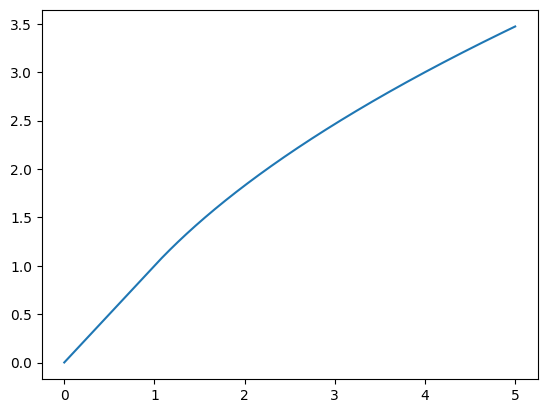

In [96]:
# this is how it looks like - linear below 1, sqrt after
yhat = torch.linspace(start=1e-3,end=5,steps=1000)
ypp = torch.zeros_like(yhat)
rl = RootLoss()

_ = [rl(yhat[idx],ypp[idx]) for idx in range(len(yhat))]
plt.plot(yhat, _)

While this loss puts even less importance on larger residuals, it didn't improve performance over SmoothL1Loss.

In [97]:
#loss = nn.L1Loss()
#loss = RootLoss()
loss = nn.SmoothL1Loss()

## Training loop

In [98]:
N_EPOCHS = 60

In [99]:
# suppress pesky UserWarning from antialias value from inside the ResNet preprocessing code
warnings.filterwarnings("ignore", category=UserWarning)

In [100]:
preds = {}
mae_historic = np.empty(N_EPOCHS, dtype=float)
clipped_mae_historic = np.empty(N_EPOCHS, dtype=float)
clip_min = 13
unclip_min = 18

clipped_mae_threshold = 11 # for clipped targets
valid_clipped_prices = clipped_prices[idxs[-VALID_SZ:]]

for epoch in range(N_EPOCHS):
    # train 1 epoch
    train_one_epoch(
        train_dataloader=train_dl,
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        criterion = loss, 
        device=device
    )
    # calculate, save and report unclipped and clipped MAE
    mae, valid_preds = evaluate(model,valid_dl,device)
    clipped_mae = mean_absolute_error(valid_clipped_prices, valid_preds)
    
    mae_historic[epoch] = mae
    clipped_mae_historic[epoch] = clipped_mae
    
    clip_min = min(clip_min, clipped_mae)
    unclip_min = min(unclip_min, mae)
    
    # if it's below a threshold also 
    if clipped_mae < clipped_mae_threshold:
        preds[epoch] = predict(model, test_dl, device, use_tqdm=False)
    
    print(
        f"Epoch {epoch+1: >2}/{N_EPOCHS}",
        f"UNCLIPPED MAE: {mae:>.3f}" + (" <--" if unclip_min == mae else "\t"), 
        f"CLIPPED MAE: {clipped_mae:>.3f}" + (" <--" if clip_min == clipped_mae else "\t"),
        sep="\t"
    )
preds[N_EPOCHS] = predict(model, test_dl, device)

Epoch  1/60	UNCLIPPED MAE: 20.002		CLIPPED MAE: 12.931 <--
Epoch  2/60	UNCLIPPED MAE: 17.961 <--	CLIPPED MAE: 10.890 <--
Epoch  3/60	UNCLIPPED MAE: 19.446		CLIPPED MAE: 12.375	
Epoch  4/60	UNCLIPPED MAE: 17.866 <--	CLIPPED MAE: 10.959	
Epoch  5/60	UNCLIPPED MAE: 84.096		CLIPPED MAE: 78.536	
Epoch  6/60	UNCLIPPED MAE: 56.778		CLIPPED MAE: 50.169	
Epoch  7/60	UNCLIPPED MAE: 108.490		CLIPPED MAE: 108.208	
Epoch  8/60	UNCLIPPED MAE: 17.919		CLIPPED MAE: 10.847 <--
Epoch  9/60	UNCLIPPED MAE: 18.615		CLIPPED MAE: 12.380	
Epoch 10/60	UNCLIPPED MAE: 16.981 <--	CLIPPED MAE: 9.910 <--
Epoch 11/60	UNCLIPPED MAE: 17.421		CLIPPED MAE: 10.349	
Epoch 12/60	UNCLIPPED MAE: 28.845		CLIPPED MAE: 23.203	
Epoch 13/60	UNCLIPPED MAE: 17.107		CLIPPED MAE: 10.188	
Epoch 14/60	UNCLIPPED MAE: 17.329		CLIPPED MAE: 10.258	
Epoch 15/60	UNCLIPPED MAE: 16.954 <--	CLIPPED MAE: 10.029	
Epoch 16/60	UNCLIPPED MAE: 16.831 <--	CLIPPED MAE: 9.760 <--
Epoch 17/60	UNCLIPPED MAE: 17.042		CLIPPED MAE: 10.098	
Epoch 18/60	UNCLIP

  0%|          | 0/120 [00:00<?, ?it/s]

In [104]:
# which ones were saved?
preds.keys()

dict_keys([1, 3, 7, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 38, 39, 42, 43, 44, 45, 46, 48, 49, 50, 52, 53, 56, 58, 60])

In [105]:
# extremely inefficient yet numba-compilable
def rolling_mean(arraylike, lambda_, exclude_first=0, fill=None):       
    res = np.copy(arraylike) if fill is None else np.full_like(arraylike, fill)
    aux = arraylike[exclude_first]
    for idx, x in enumerate(arraylike[exclude_first:]):
        aux = aux*lambda_ + x*(1-lambda_)
        res[idx+exclude_first] = aux
    return res

Min Unclipped MAE  at 20
Min Clipped MAE  at 18


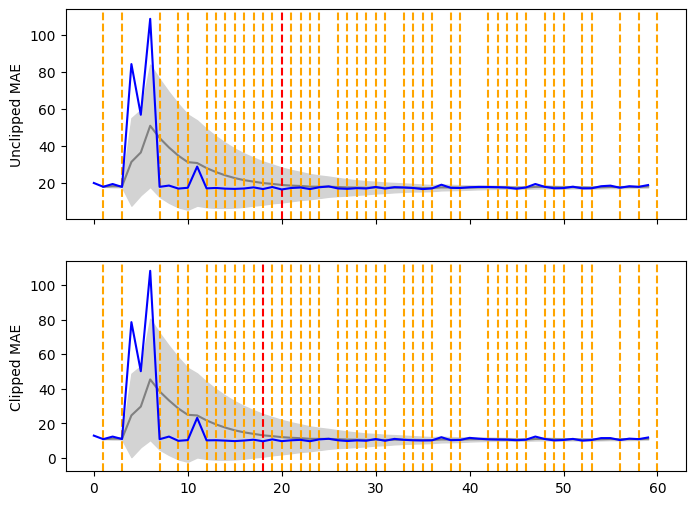

In [106]:
fig, axes = plt.subplots(figsize=(8,6), nrows=2, sharex=True)

# plot rolling mean+-std
for ax, historic, name in zip(axes, 
                              (mae_historic, clipped_mae_historic), 
                              ("Unclipped MAE", "Clipped MAE")):
    lambda_ = 0.8
    ewma = rolling_mean(historic, lambda_, 1, np.nan)
    ewmstd = np.sqrt(rolling_mean((historic-ewma)**2,lambda_, 1, 0))
    ax.fill_between(range(len(historic)),ewma+ewmstd, ewma-ewmstd,color='lightgray')
    ax.plot(ewma, color='gray')

    min_mae = np.argmin(historic)
    print("Min",name," at",min_mae)
    for k in preds.keys():
        color = 'red' if k==min_mae else 'orange'
        ax.axvline(k, color=color, linestyle='dashed')

    # plot valid MAE trajectory
    ax.plot(historic, color='blue')
    ax.set_ylabel(name)
plt.show()

In [109]:
# selecting the min unclipped MAE model
selected_idx = 20

In [110]:
# generate submission
submit(preds[selected_idx],"resnet"+str(selected_idx)+("sp" if USE_SOFTPLUS else ""))